# Analysis Signed Saliency Maps

In [1]:
# deep learning libraries
import torch
import numpy as np
from torch.utils.data import DataLoader

# other libraries
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import List, Tuple

# own modules
from src.train.utils import preprocess_imagenette, set_seed, load_cifar10_data, load_imagenette_data
from src.explain.saliency_maps import SaliencyMap, PositiveSaliencyMap, NegativeSaliencyMap, ActiveSaliencyMap, \
    InactiveSaliencyMap
from src.explain.benchmarks import deletion
from src.explain.utils import auc, format_image

# set seed
set_seed(42)
    
# set device and check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(f'device: {device}')

# static variables
DATA_PATH = {'cifar10': './data/cifar10', 'imagenette': './data/imagenette/original_data'}
POSTPROCESS_DATA_PATH = {'cifar10': None, 'imagenette': './data/imagenette/postprocess_data'}
NUMBER_OF_CLASSES = 10

device: cuda


## Examples Selection

In [10]:

def generate_examples(model: torch.nn.Module, dataloader: DataLoader, examples_path: str, 
                      save_path : str) -> List[plt.Figure]:
    # empty gpu
    # torch.cuda.empty_cache()
    
    iterator = iter(dataloader)
    input_, label = next(iterator)
    height = input_.shape[2]
    width = input_.shape[3]
    
    # create directory for saving correct examples if it does not exist
    if not os.path.isdir(examples_path):
        os.makedirs(examples_path)

    if len(os.listdir(examples_path)) == 0:

        # initialize correct and wrong examples vectors
        examples = NUMBER_OF_CLASSES * [None]

        for input_, label in dataloader:
            input_ = input_.to(device)
            label = label.to(device)
            output = torch.argmax(model(input_), dim=1)

            # ser correct examples values
            if output == label:
                if examples[label] is None:
                    examples[label] = input_

        # write examples in memory
        i = 0
        for example in examples:
            torch.save(example, f'{examples_path}/{i}.pt')
            i += 1

    # create tensors for examples
    examples = torch.zeros((NUMBER_OF_CLASSES, 3, height, width)).to(device)

    # load examples
    for i in range(NUMBER_OF_CLASSES):
        examples[i] = torch.load(f'{examples_path}/{i}.pt').squeeze(0).to(device)
        
    # check if visualization path is created
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
        
    figures = []
    for i in range(examples.shape[0]):
        figure = plt.figure()
        plt.axis('off')
        plt.imshow(format_image(examples[i]), cmap='hot')
        plt.savefig(f'{save_path}/{i}.png', bbox_inches='tight', pad_inches=0, format='png', dpi=300)
        plt.close()
        figures.append(figure)
        
    return figures
        


In [15]:

def generate_saliency_maps(method_name: str, model: torch.nn.Module, examples_path: str, 
                           save_path : str) -> List[plt.Figure]:
    
    # define dimensions
    height = torch.load(f'{examples_path}/{0}.pt').shape[2]
    width = torch.load(f'{examples_path}/{0}.pt').shape[3]
    
    # create tensors for examples
    examples = torch.zeros((NUMBER_OF_CLASSES, 3, height, width)).to(device)

    # load examples
    for i in range(NUMBER_OF_CLASSES):
        examples[i] = torch.load(f'{examples_path}/{i}.pt').squeeze(0).to(device)
    
    # define methods
    methods = {'saliency map': SaliencyMap(model), 'positive saliency map': PositiveSaliencyMap(model), 
            'negative saliency map': NegativeSaliencyMap(model), 'active saliency map': ActiveSaliencyMap(model), 
            'inactive saliency map': InactiveSaliencyMap(model)}
    
    method = methods[method_name]
    saliency_maps =  method.explain(examples)
    
    # define save path
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    
    figures = []
    for i in range(saliency_maps.shape[0]):
        figure = plt.figure()
        plt.axis('off')
        plt.imshow(saliency_maps[i].detach().cpu().numpy(), cmap='hot')
        plt.savefig(f'{save_path}/{i}.png', bbox_inches='tight', pad_inches=0, format='png', dpi=300)
        plt.close()
        figures.append(figure)
        
    return figures
        
    

### Cifar10

In [4]:
# define dataset name
dataset_name = 'cifar10'

# load data
_, val_data = load_cifar10_data(DATA_PATH[dataset_name], batch_size=1)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# define model type and model
model_type = 'cnn'
model = torch.load(f'./models/{dataset_name}/{model_type}_pretrained_False_lr_0.001_epochs_50.pt').to(device)
figures = generate_examples(model, val_data, f'./data/{dataset_name}/examples/{model_type}', 
                            f'./visualizations/examples/{dataset_name}/{model_type}/images')

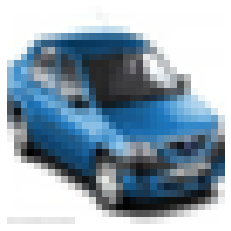

In [7]:
figures[1]

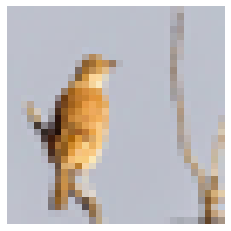

In [8]:
figures[2]

In [16]:
figures = generate_saliency_maps('saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/saliency_map')


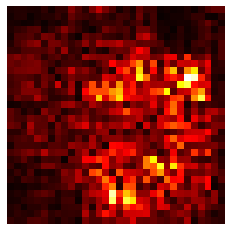

In [17]:
figures[1]

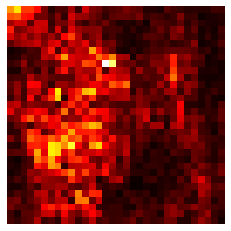

In [18]:
figures[2]

In [19]:
figures = generate_saliency_maps('positive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/positive_saliency_map')


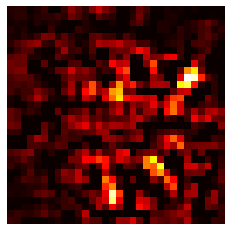

In [20]:
figures[1]

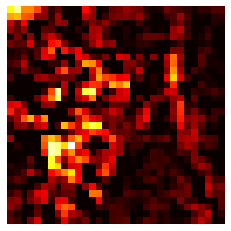

In [21]:
figures[2]

In [22]:
figures = generate_saliency_maps('negative saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/negative_saliency_map')


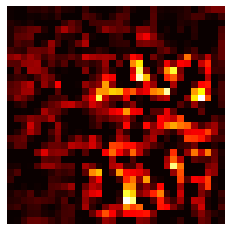

In [23]:
figures[1]

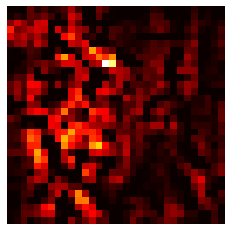

In [24]:
figures[2]

In [25]:
figures = generate_saliency_maps('active saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/active_saliency_map')


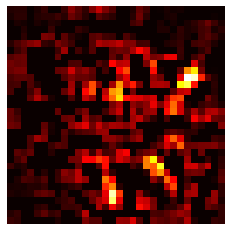

In [26]:
figures[1]

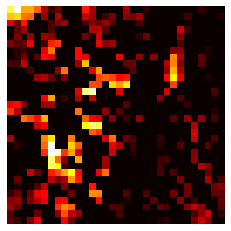

In [27]:
figures[2]

In [28]:
figures = generate_saliency_maps('inactive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/inactive_saliency_map')

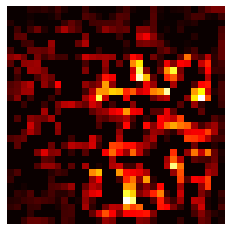

In [29]:
figures[1]

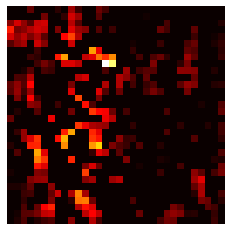

In [30]:
figures[2]

In [31]:
# define model type and model
model_type = 'resnet18'
model = torch.load(f'./models/{dataset_name}/{model_type}_pretrained_False_lr_0.001_epochs_50.pt').to(device)
figures = generate_examples(model, val_data, f'./data/{dataset_name}/examples/{model_type}', 
                            f'./visualizations/examples/{dataset_name}/{model_type}/images')

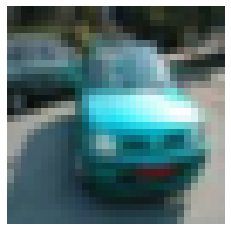

In [32]:
figures[1]

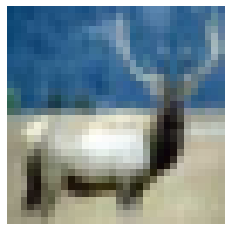

In [35]:
figures[4]

In [36]:
figures = generate_saliency_maps('saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/saliency_map')


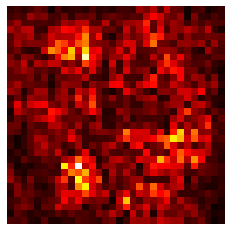

In [37]:
figures[1]

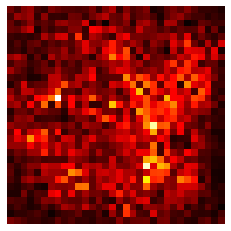

In [38]:
figures[4]

In [39]:
figures = generate_saliency_maps('positive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/positive_saliency_map')


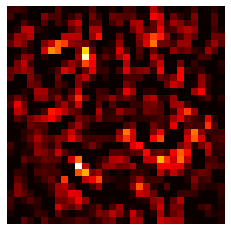

In [40]:
figures[1]

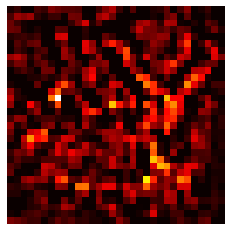

In [41]:
figures[4]

In [42]:
figures = generate_saliency_maps('negative saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/negative_saliency_map')


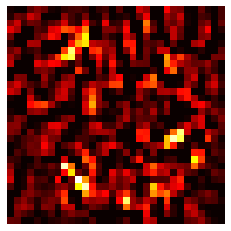

In [43]:
figures[1]

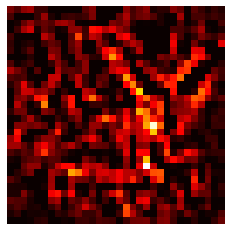

In [44]:
figures[4]

In [45]:
figures = generate_saliency_maps('active saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/active_saliency_map')


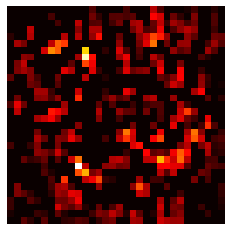

In [46]:
figures[1]

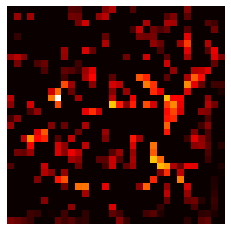

In [47]:
figures[4]

In [48]:
figures = generate_saliency_maps('inactive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/inactive_saliency_map')

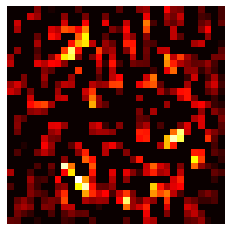

In [49]:
figures[1]

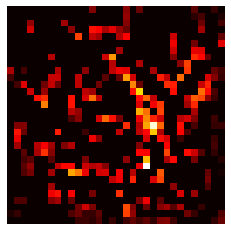

In [50]:
figures[4]

### Imagenette

In [51]:
# define dataset name
dataset_name = 'imagenette'

# load data
# preprocess step
if not os.path.isdir(POSTPROCESS_DATA_PATH[dataset_name]):
    preprocess_imagenette(DATA_PATH[dataset_name], POSTPROCESS_DATA_PATH[dataset_name])

# load data
_, val_data = load_imagenette_data(POSTPROCESS_DATA_PATH[dataset_name],  batch_size=1)

In [52]:
# define model type and model
model_type = 'cnn'
model = torch.load(f'./models/{dataset_name}/{model_type}_pretrained_False_lr_0.001_epochs_50.pt').to(device)
figures = generate_examples(model, val_data, f'./data/{dataset_name}/examples/{model_type}', 
                            f'./visualizations/examples/{dataset_name}/{model_type}/images')

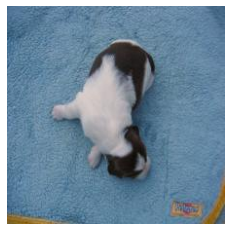

In [66]:
figures[3]

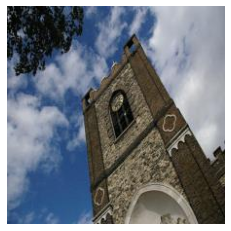

In [67]:
figures[6]

In [68]:
figures = generate_saliency_maps('saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/saliency_map')

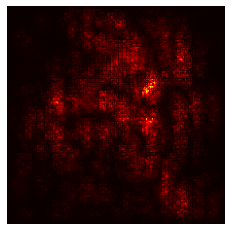

In [69]:
figures[3]

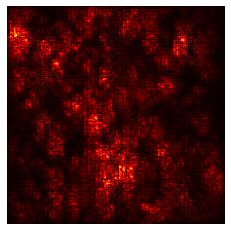

In [70]:
figures[6]

In [71]:
figures = generate_saliency_maps('positive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/positive_saliency_map')

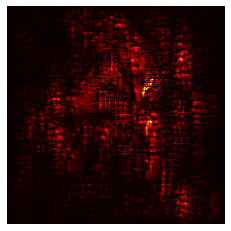

In [72]:
figures[3]

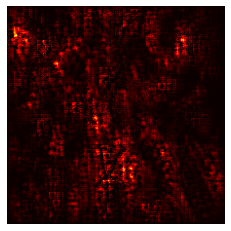

In [73]:
figures[6]

In [74]:
figures = generate_saliency_maps('negative saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/negative_saliency_map')

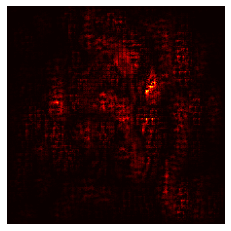

In [75]:
figures[3]

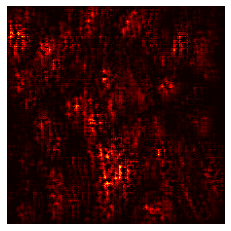

In [76]:
figures[6]

In [77]:
figures = generate_saliency_maps('active saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/active_saliency_map')

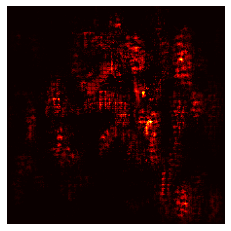

In [78]:
figures[3]

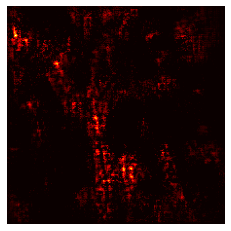

In [79]:
figures[6]

In [80]:
figures = generate_saliency_maps('inactive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/inactive_saliency_map')

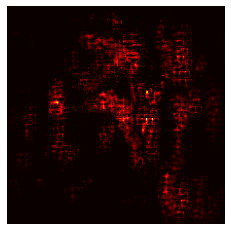

In [81]:
figures[3]

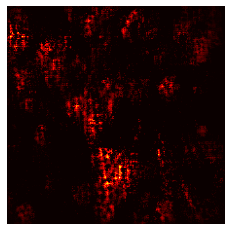

In [82]:
figures[6]

In [83]:
# define model type and model
model_type = 'resnet18'
model = torch.load(f'./models/{dataset_name}/{model_type}_pretrained_False_lr_0.001_epochs_50.pt').to(device)
figures = generate_examples(model, val_data, f'./data/{dataset_name}/examples/{model_type}', 
                            f'./visualizations/examples/{dataset_name}/{model_type}/images')

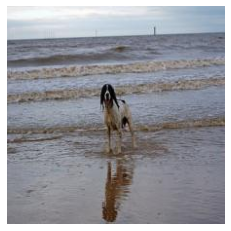

In [84]:
figures[3]

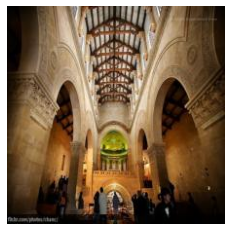

In [94]:
figures[6]

In [95]:
figures = generate_saliency_maps('saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/saliency_map')

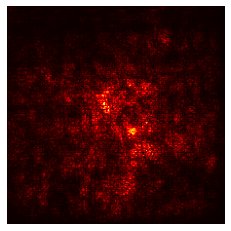

In [96]:
figures[3]

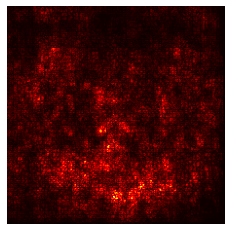

In [97]:
figures[6]

In [98]:
figures = generate_saliency_maps('positive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/positive_saliency_map')

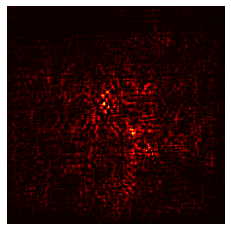

In [99]:
figures[3]

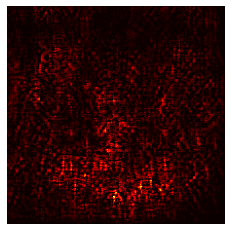

In [100]:
figures[6]

In [101]:
figures = generate_saliency_maps('negative saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/negative_saliency_map')

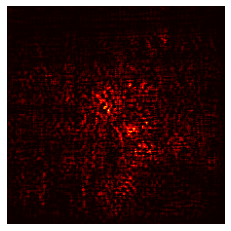

In [102]:
figures[3]

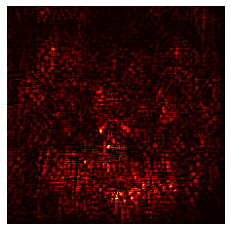

In [103]:
figures[6]

In [105]:
figures = generate_saliency_maps('active saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/active_saliency_map')

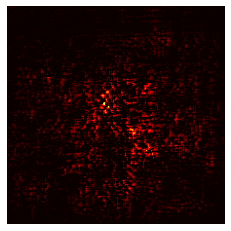

In [106]:
figures[3]

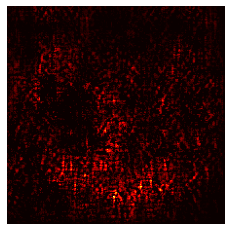

In [107]:
figures[6]

In [108]:
figures = generate_saliency_maps('inactive saliency map', model, f'./data/{dataset_name}/examples/{model_type}', 
                                 f'./visualizations/examples/{dataset_name}/{model_type}/inactive_saliency_map')

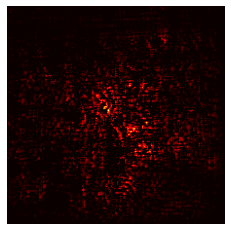

In [109]:
figures[3]

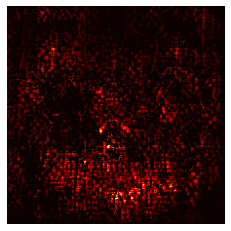

In [110]:
figures[6]

## Deletion Benchmark

In [5]:
def generate_graph(dataset: str, model_type: str, batch_size: int) -> None:
    # empty gpu
    torch.cuda.empty_cache()
    
    # hyperparameters
    lr = 1e-3
    pretrained = False
    epochs = 50

    if dataset == 'cifar10':
        _, val_data = load_cifar10_data(DATA_PATH[dataset], batch_size=batch_size)
    elif dataset == 'imagenette':
        # preprocess step
        if not os.path.isdir(POSTPROCESS_DATA_PATH[dataset]):
            preprocess_imagenette(DATA_PATH[dataset], POSTPROCESS_DATA_PATH[dataset])

        # load data
        _, val_data = load_imagenette_data(POSTPROCESS_DATA_PATH[dataset],  batch_size=batch_size)
        
    else:
        raise ValueError('Invalid dataset value')

    # define model name and tensorboard writer
    model_path = f'./models/{dataset}/{model_type}_pretrained_{pretrained}_lr_{lr}_epochs_{epochs}.pt'
    model = torch.load(model_path)

    methods = {'saliency map': SaliencyMap(model), 'positive saliency map': PositiveSaliencyMap(model), 
            'negative saliency map': NegativeSaliencyMap(model), 'active saliency map': ActiveSaliencyMap(model), 
            'inactive saliency map': InactiveSaliencyMap(model)}

    # initialize percentages
    percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    results = {}
    for method_name in list(methods.keys()):
        results[method_name] = deletion(val_data, methods[method_name], percentages)
        
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(percentages, np.transpose(np.array(list(results.values()))), marker='o')
    plt.xlabel('pixels deleted [%]')
    plt.ylabel('accuracy')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.ylim([0, 1])
    plt.grid()
    plt.legend(list(results.keys()))
    plt.savefig(f'./visualizations/graphs/{dataset}/{model_type}_pretrained_{pretrained}_lr_{lr}_epochs_{epochs}.pdf', 
                bbox_inches='tight', pad_inches=0, format='pdf')
    plt.show()
    
    for method in results:
        auc_score = auc(results[method], 0.1)
        print(f'AUC score of {method}: {auc_score:.4f}')
        

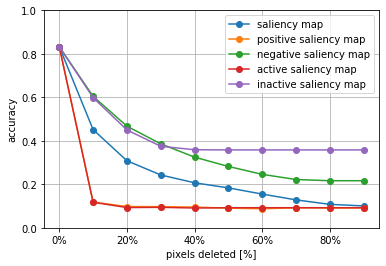

AUC score of saliency map: 0.2251
AUC score of positive saliency map: 0.1232
AUC score of negative saliency map: 0.3274
AUC score of active saliency map: 0.1228
AUC score of inactive saliency map: 0.3810


In [6]:
dataset = 'imagenette'
model_type = 'resnet18'
generate_graph(dataset, model_type, 128)

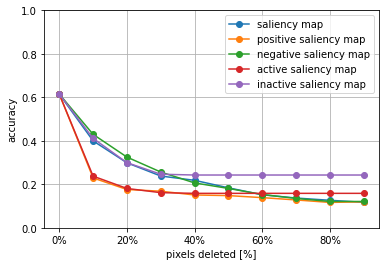

AUC score of saliency map: 0.2120
AUC score of positive saliency map: 0.1623
AUC score of negative saliency map: 0.2176
AUC score of active saliency map: 0.1759
AUC score of inactive saliency map: 0.2600


In [7]:
dataset = 'imagenette'
model_type = 'cnn'
generate_graph(dataset, model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


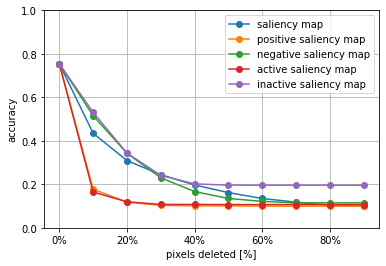

AUC score of saliency map: 0.2131
AUC score of positive saliency map: 0.1327
AUC score of negative saliency map: 0.2176
AUC score of active saliency map: 0.1357
AUC score of inactive saliency map: 0.2577


In [8]:
dataset = 'cifar10'
model_type = 'resnet18'
generate_graph(dataset, model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


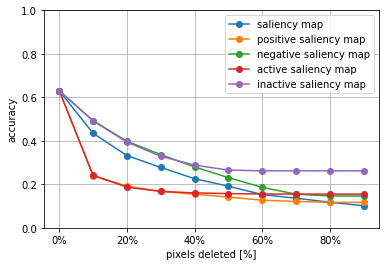

AUC score of saliency map: 0.2234
AUC score of positive saliency map: 0.1633
AUC score of negative saliency map: 0.2613
AUC score of active saliency map: 0.1771
AUC score of inactive saliency map: 0.3000


In [9]:
dataset = 'cifar10'
model_type = 'cnn'
generate_graph(dataset, model_type, 128)

## Comparison Approximation

In [42]:
def approximation_ratio(dataset: str, first_method: str, second_method: str, model_type: str, batch_size: int) -> None:
    # empty gpu
    torch.cuda.empty_cache()
    
    # hyperparameters
    lr = 1e-3
    pretrained = False
    epochs = 50

    if dataset == 'cifar10':
        _, val_data = load_cifar10_data(DATA_PATH[dataset], batch_size=batch_size)
    elif dataset == 'imagenette':
        # preprocess step
        if not os.path.isdir(POSTPROCESS_DATA_PATH[dataset]):
            preprocess_imagenette(DATA_PATH[dataset], POSTPROCESS_DATA_PATH[dataset])

        # load data
        _, val_data = load_imagenette_data(POSTPROCESS_DATA_PATH[dataset],  batch_size=batch_size)
        
    else:
        raise ValueError('Invalid dataset value')

    # define model name and tensorboard writer
    model_path = f'./models/{dataset}/{model_type}_pretrained_{pretrained}_lr_{lr}_epochs_{epochs}.pt'
    model = torch.load(model_path)

    methods = {'saliency map': SaliencyMap(model), 'positive saliency map': PositiveSaliencyMap(model), 
            'negative saliency map': NegativeSaliencyMap(model), 'active saliency map': ActiveSaliencyMap(model), 
            'inactive saliency map': InactiveSaliencyMap(model)}
    
    # initialize methods
    first_method = methods[first_method]
    second_method = methods[second_method]

    # initialize percentages
    num_equals = 0
    num_pixels = 0
    for images, labels in val_data:
        images = images.to(device)
        saliency_maps_first_method = first_method.explain(images)
        saliency_maps_second_method = second_method.explain(images)
        
        num_equals += torch.sum(saliency_maps_first_method[saliency_maps_first_method!=0]==\
            saliency_maps_second_method[saliency_maps_first_method!=0])
        num_pixels += torch.sum(saliency_maps_first_method!=0)
        
    equal_ratio = num_equals / num_pixels
    
    print(f'equal ratio: {equal_ratio.item():.4f}')
    
    return None
        

In [43]:
dataset = 'cifar10'
model_type = 'cnn'
approximation_ratio(dataset, 'positive saliency map', 'active saliency map', model_type, 128)

Files already downloaded and verified
Files already downloaded and verified
equal ratio: 0.4521


In [35]:
dataset = 'cifar10'
model_type = 'cnn'
approximation_ratio(dataset, 'negative saliency map', 'inactive saliency map', model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


0.45331937074661255

In [36]:
dataset = 'cifar10'
model_type = 'resnet18'
approximation_ratio(dataset, 'positive saliency map', 'active saliency map', model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


0.4295791685581207

In [37]:
dataset = 'cifar10'
model_type = 'resnet18'
approximation_ratio(dataset, 'negative saliency map', 'inactive saliency map', model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


0.4284229874610901

In [38]:
dataset = 'imagenette'
model_type = 'cnn'
approximation_ratio(dataset, 'positive saliency map', 'active saliency map', model_type, 128)

0.23868006467819214

In [39]:
dataset = 'imagenette'
model_type = 'cnn'
approximation_ratio(dataset, 'negative saliency map', 'inactive saliency map', model_type, 128)

0.24043509364128113

In [40]:
dataset = 'imagenette'
model_type = 'resnet18'
approximation_ratio(dataset, 'positive saliency map', 'active saliency map', model_type, 128)

0.4413593113422394

In [41]:
dataset = 'imagenette'
model_type = 'resnet18'
approximation_ratio(dataset, 'negative saliency map', 'inactive saliency map', model_type, 128)

0.4424918293952942